# SSCx Dissemination.

We analyze circuits developed under the SSCx Dissemination project.


In [1]:
from collections import OrderedDict
from tqdm import tqdm
from dmt.tk.plotting import Bars, LinePlot, Crosses
from dmt.data.observation import measurement
from dmt.tk.plotting.multi import MultiPlot
from neuro_dmt.models.bluebrain.circuit.geometry import Cuboid
from neuro_dmt.library.users.visood.sscx_dissemination.analyses import *

While using this notebook for development, we might need to reload the adapter:

In [2]:
sscxdiss = SSCxDisseminationCircuit()

In [3]:
sscxdiss.variations

bio0: Not Available
bio1: Not Available
bio2: Not Available
bio3: Not Available
bio4: Not Available
bio5: Not Available
biom: 'Bio_M/20191206'
mock: 'MOCK'

We will need to parameterize our analysis:

In [4]:
spec = AnalysisParameterization()
spec.field_dict

{'morphologies_interneurons': ['BP',
  'BTC',
  'CHC',
  'DB',
  'LBC',
  'NBC',
  'MC',
  'SBC',
  'SSC'],
 'number_cortical_thickness_bins': 50,
 'path_reports': '/Users/vishalsoodmuchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/notebooks/reports',
 'sample_size': 100,
 'size_roi': array([50., 50., 50.])}

In [5]:
#circuit_model = sscxdiss.circuit(sscxdiss.variations.mock)
circuit_model = sscxdiss.circuit(sscxdiss.variations.biom)
adapter = sscxdiss.adapter

In [6]:
from importlib import reload
from neuro_dmt.models.bluebrain.circuit.adapter import adapter as ad
from neuro_dmt.models.bluebrain.circuit import model as md
from neuro_dmt.library.users.visood.sscx_dissemination.analyses.tools\
    import pathway_measurement as pm
from neuro_dmt.analysis import reporting as rp
adapter =\
    ad.BlueBrainCircuitAdapter()
model =\
    md.BlueBrainCircuitModel()
reporter =\
    rp.CheetahReporter(
        path_output_folder=os.path.join(
            spec.path_reports, "analyses"))

 We will develop our analysis of the SSCx Dissemination circuits as a growing
 list of analyzed phenomena:

In [7]:
phenomenon = OrderedDict()

For each **DMT** analysis we will need to define an interface defining the
methods that the analysis uses to query a circuit model.
Instead of defining an interface for each analysis, we have collected all the
interface methods for composition and connectome analyses:

In [8]:
from neuro_dmt.library.users.visood.sscx_dissemination.analyses.composition\
    import CompositionAnalysesSuite
CompositionAdapterInterface = CompositionAnalysesSuite.AdapterInterface

To save reports, we will use a reporter.

In [9]:
from neuro_dmt.analysis.reporting import CheetahReporter
reporter = CheetahReporter(
    path_output_folder=os.path.join(
        spec.path_reports, "analyses"))

# Circuit Composition
Rat *Somatoseonsory Cortex* circuits are atlas based.
Four sub-regions of the SSCx were populated:ec

In [10]:
populated_regions =\
    adapter.get_brain_regions(circuit_model)
populated_regions

[S1FL, S1Sh, S1HL, S1Tr]
Categories (4, object): [S1FL, S1Sh, S1HL, S1Tr]

We will use parameters to measure composition phenomena:

In [11]:
def get_regions(adapter, model):
    """
    Get regions...
    """
    return pd.DataFrame(
        adapter.get_brain_regions(model),
        columns=["region"])

def get_layers(adapter, model):
    """..."""
    return pd.DataFrame(
        adapter.get_layers(model),
        columns=["layer"])
    
def get_regions_and_layers(adapter, model):
    """
    Get regions and layers for the model.
    """
    regions = adapter.get_brain_regions(model)
    layers = adapter.get_layers(model)
    return pd.DataFrame(
        [[region, layer] for region in regions for layer in layers],
        columns=["region", "layer"])

We can count the number of cells in each region.
We will use **DMT** to define and run analyses. 
A DMT analysis requires a method to measure the analyzed phenomenon.
We define such a method to count cells:

## SSCx Subregions

Four sub-regions of the SSCx were populated:

### Region Volumes

To get an idea about the relative sizes of layers and sub-regions, we analyze
the volume of each modulated sub-region, layer pair in the circuit.

In [12]:
def measurement_region_volume(
        adapter, circuit_model,
        **query):
    """
    Volume of the region specified by `query`.
    """
    spatial_query = terminology.circuit.get_spatial_query(query)
    return adapter.get_spatial_volume(circuit_model, **spatial_query)

def add_total_volume(measurement):
    return\
        pd.concat([
            measurement,
            measurement.groupby(["dataset", "region"])\
                       .agg("sum")\
                       .assign(layer="total")\
                       .reset_index()\
                       .set_index(["dataset", "region", "layer"])])

phenomenon["region_volume"] =\
    Phenomenon(
        "Volume",
        description="Volume of a brain-region.",
        group="Composition")
analysis_region_volumes =\
    BrainCircuitAnalysis(
        phenomenon=phenomenon["region_volume"],
        introduction="""
        Volumes of the populated subregions and layers of SSCx are analyzed.
        """,
        methods="""
        Voxels were counted in each sub-region, layer were counted and 
        multiplied with voxel volume.
        """,
        AdapterInterface=CompositionAdapterInterface,
        measurement_parameters=Parameters(get_regions_and_layers),
        sample_measurement=measurement_region_volume,
        add_columns = add_total_volume,
        sampling_methodology=terminology.sampling_methodology.exhaustive,
        plotter=Bars(xvar="region",
                     xlabel="Region",
                     yvar="volume",
                     ylabel="Volume",
                     gvar="layer"),
        report=CircuitAnalysisReport)

100%|██████████| 24/24 [01:14<00:00,  3.09s/it]


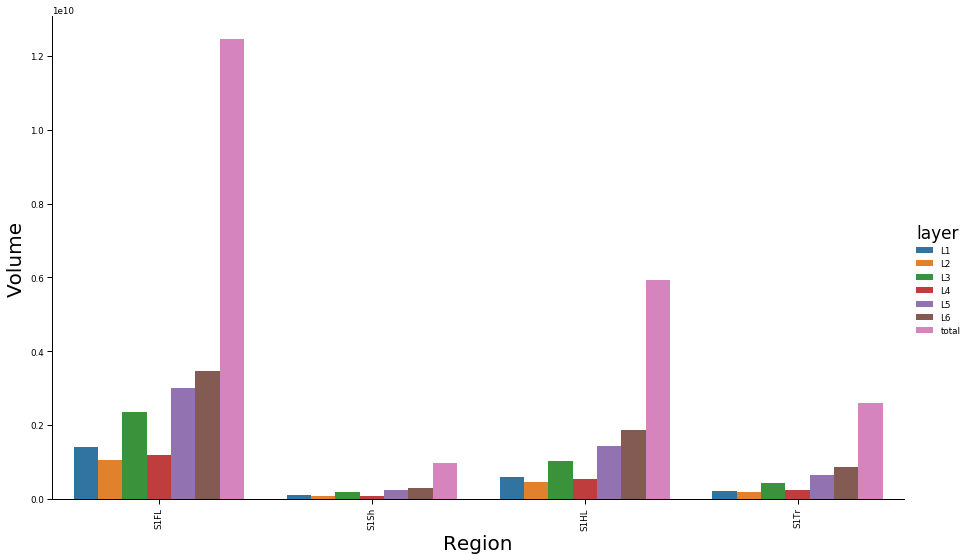

In [15]:
report_volumes = analysis_region_volumes(circuit_model, adapter)

In [16]:
reload(rp)
reporter =\
    rp.CheetahReporter(
        path_output_folder=os.path.join(
            spec.path_reports, "analyses"))
reporter.post(report_volumes)

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/analysis/reporting/__init__.py Logger
DEBUGINFO@<2020-03-06 15:41:52>                                                 
.post(report=<neuro_dmt.analysis.reporting.CircuitAnalysisReport object at 0x14e4a34d0>,
                   template=None,
                   path_output_folder=None,
                   output_subfolder=None,
                   report_file_name=report.html,
                   strict=False,
                   with_time_stamp=True,
                   path_main_report=None,
                   title_main_report=None,
                   section_index=None,
                   chapter_index=None)

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/analysis/reporting/__init__.py Logger
INFO@<2020-03-06 15:41:52>                                                      
Post report volume at
	 /Users/vishalsoodmuchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/s

'/Users/vishalsoodmuchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/notebooks/reports/analyses/volume/20200306/154856'

### Layer Thickness

Layer thickness is tricky to define for an atlas based circuit.
We expect that for a given sub-region a sample of layer thicknesses can be drawn.
Our next analysis uses this technique and plots the distribution of drawn samples
for each sub-region.

In [70]:
def measurement_thickness(
        adapter, circuit_model,
        region=None,
        **kwargs):
    """
    Measure layer thickness in the given region.
    """
    wide = adapter.get_layer_thickness_values(circuit_model, region=region)
    wide.columns.name = "layer"
    return\
        pd.concat([wide.iloc[i] for i in range(wide.shape[0])])\
          .rename("thickness")

In [96]:
phenomenon["thickness"] =\
    Phenomenon(
        "Thickness",
        description="Thickness of layers.",
        group="Composition")

analysis_layer_thickness =\
    BrainCircuitAnalysis(
        phenomenon=phenomenon["thickness"],
        introduction="""
        Thickness of layers measured in each region modeled in the circuit.
        """,
        methods="""
        Thickness of layers were measured as the shortest top-bottom line
        passing through each voxel in the voxelized space.
        """,
        AdapterInterface=CompositionAdapterInterface,
        measurement_parameters=Parameters(get_regions),
        sampling_methodology=terminology.sampling_methodology.exhaustive,
        sample_measurement=measurement_thickness,
        measurement_collection=measurement.collection.series_type,
        plotter=Bars(xvar="region",
                     xlabel="Region",
                     yvar="thickness",
                     ylabel="Thickness",
                     gvar="layer"),
        report=CircuitAnalysisReport)





  0%|          | 0/4 [00:00<?, ?it/s]



 25%|██▌       | 1/4 [00:24<01:12, 24.28s/it]



 50%|█████     | 2/4 [00:50<00:49, 24.99s/it]



 75%|███████▌  | 3/4 [01:13<00:24, 24.37s/it]



100%|██████████| 4/4 [01:37<00:00, 24.27s/it]


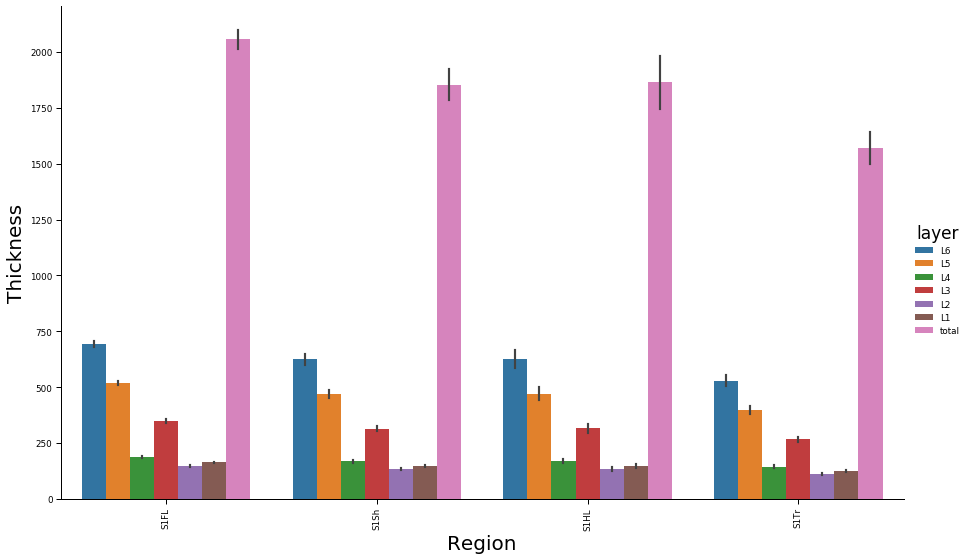

In [97]:
report_thickness =\
    analysis_layer_thickness(circuit_model, adapter)

In [98]:
reporter.post(report_thickness)

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/analysis/reporting/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
.post(report=<neuro_dmt.analysis.reporting.CircuitAnalysisReport object at 0x19b46dcd0>,
                   template=None,
                   path_output_folder=None,
                   output_subfolder=None,
                   report_file_name=report.html,
                   strict=False,
                   with_time_stamp=True,
                   path_main_report=None,
                   title_main_report=None,
                   section_index=None,
                   chapter_index=None)

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/analysis/reporting/__init__.py Logger
INFO@<2020-03-06 15:56:00>                                                      
Post report thickness at
	 /Users/vishalsoodmuchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visoo

'/Users/vishalsoodmuchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/notebooks/reports/analyses/thickness/20200306/175218'

## Cell Distribution

In this section we study the distribution of cells over the physical geometry
of the circuit.


In [19]:
def random_position(
        adapter, circuit_model,
        **query):
    """
    Random position in circuit region specified by `query`.
    """
    spatial_query = terminology.circuit.get_spatial_query(query)
    return adapter.random_position(circuit_model, **spatial_query)
    
def random_box(
        adapter, circuit_model, 
        size_roi=100., **query):
    """
    Random cuboid in circuit region specified by `query`.
    """
    position = random_position(adapter, circuit_model, **query)
    return Cuboid(position - size_roi, position + size_roi)\
        if position is not None else None

def measurement_cell_count_using_sampling(
        adapter, circuit_model,
        size_roi=100., **query):
    """
    Measure the number of cells in a spatial location specified by the query.
    """
    box = random_box(adapter, circuit_model, size_roi=size_roi, **query)
    return adapter.get_cells(circuit_model, roi=box).shape[0]\
        if box is not None else 0.

### Cell Count

Circuit regions and layers are not the same size, and contain different densities
of cells.

In [20]:
phenomenon["cell_count"] =\
    Phenomenon("Cell Count", 
               description="Number of cells in the circuit.",
               group="Composition")
    
analysis_cell_count =\
    BrainCircuitAnalysis(
        phenomenon=phenomenon["cell_count"],
        introduction="""
        Number of cells in each of the populated sub-regions are analyzed.
        """,
        methods="""
        Cells were counted in randomly sampled cubic boxes of side $size_roi.
        Each sampled box was conditioned to lie in the spatial location 
        specified by brain-region and layer queried. For each spatial query,
        the measured sample contained $sample_size boxes.
        """,
        AdapterInterface=CompositionAdapterInterface,
        measurement_parameters=Parameters(get_regions_and_layers),
        sample_measurement=measurement_cell_count_using_sampling,
        sample_size=20,
        plotter=MultiPlot(mvar="region",
                          plotter=Bars(xvar="layer",
                                       xlabel="Layer",
                                       yvar="cell_count",
                                       ylabel="Cell Count")),
        report=CircuitAnalysisReport)
                                       

  0%|          | 0/480 [00:00<?, ?it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1FL', 'layer': 'L1'}.
                



  0%|          | 1/480 [00:07<58:59,  7.39s/it]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 

            get_voxel_positions for voxel_ids of shape (23956, 3)
            

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14d96aad0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14d96aad0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/sit

  2%|▏         | 8/480 [00:07<28:36,  3.64s/it]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14d962e10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14d962e10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14d962cd0>}

/Users/vi

  3%|▎         | 14/480 [00:07<13:59,  1.80s/it]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14b42eb50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14b42eb50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14b2f5dd0>}

/Users/vi

  4%|▎         | 17/480 [00:07<09:49,  1.27s/it]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14d962e90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14d962e90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14d962a90>}

/Users/vi

  5%|▌         | 24/480 [00:12<06:28,  1.17it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 

            get_voxel_positions for voxel_ids of shape (18138, 3)
            

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14ad14910>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14ad14910>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/sit

  6%|▌         | 27/480 [00:12<04:36,  1.64it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120cc5650>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120cc5650>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120cb5dd0>}

/Users/vi

  7%|▋         | 33/480 [00:12<02:23,  3.12it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x121250c10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x121250c10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x121029b50>}

/Users/vi

  8%|▊         | 39/480 [00:12<01:19,  5.55it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1190521d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1190521d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14ad14fd0>}

/Users/vi

  9%|▉         | 42/480 [00:17<04:06,  1.78it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 

            get_voxel_positions for voxel_ids of shape (40583, 3)
            

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x117ff4190>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x117ff4190>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/sit

 10%|▉         | 47/480 [00:17<02:10,  3.31it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x146507d50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x146507d50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120fddc10>}

/Users/vi

 11%|█         | 51/480 [00:17<01:16,  5.64it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120fcacd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120fcacd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120be2d90>}

/Users/vi

 11%|█▏        | 55/480 [00:17<00:49,  8.56it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120be2e50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120be2e50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120be2e50>}

/Users/vi

 12%|█▏        | 58/480 [00:18<00:40, 10.50it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x11e1c5310>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x11e1c5310>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120be2a90>}

/Users/vi

 13%|█▎        | 61/480 [00:22<03:38,  1.92it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 

            get_voxel_positions for voxel_ids of shape (20429, 3)
            

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x11e1c5ed0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x11e1c5ed0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/sit

 14%|█▍        | 67/480 [00:22<01:56,  3.56it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120fc2890>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120fc2890>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x117ff0610>}

/Users/vi

 15%|█▌        | 72/480 [00:23<01:06,  6.09it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x117ff0e10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x117ff0e10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x121250f10>}

/Users/vi

 16%|█▌        | 77/480 [00:23<00:42,  9.43it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x121250e10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x121250e10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14d962a50>}

/Users/vi

 16%|█▋        | 79/480 [00:23<00:35, 11.16it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14ad04cd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14ad04cd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14b468350>}

/Users/vi

 18%|█▊        | 84/480 [00:28<03:22,  1.95it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 

            get_voxel_positions for voxel_ids of shape (51522, 3)
            

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x121009f50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x121009f50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/sit

 18%|█▊        | 87/480 [00:28<02:26,  2.69it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14d962290>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14d962290>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14d962290>}

/Users/vi

 19%|█▉        | 93/480 [00:28<01:19,  4.86it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x121250e10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x121250e10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x121010cd0>}

/Users/vi

 20%|██        | 96/480 [00:28<01:00,  6.33it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120f0a090>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120f0a090>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120f0aad0>}

/Users/vi

 21%|██        | 99/480 [00:28<00:48,  7.89it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x121250bd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x121250bd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x121250b10>}

/Users/vi

 21%|██        | 101/480 [00:33<05:04,  1.24it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 

            get_voxel_positions for voxel_ids of shape (59575, 3)
            

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14d965f10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14d965f10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/sit

 22%|██▏       | 106/480 [00:33<02:37,  2.38it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x11e1bbc10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x11e1bbc10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x11e1b7ad0>}

/Users/vi

 23%|██▎       | 112/480 [00:34<01:23,  4.39it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x11e1c5310>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x11e1c5310>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x11801ff90>}

/Users/vi

 24%|██▍       | 115/480 [00:34<01:04,  5.66it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x121265690>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x121265690>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120d78a50>}

/Users/vi

 25%|██▍       | 119/480 [00:34<00:41,  8.66it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x121265150>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x121265150>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1212650d0>}

/Users/vi

 26%|██▌       | 125/480 [00:38<02:47,  2.12it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 

            get_voxel_positions for voxel_ids of shape (1793, 3)
            

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14d96d810>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14d96d810>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site

 28%|██▊       | 132/480 [00:38<01:26,  4.04it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1190c4410>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1190c4410>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1515affd0>}

/Users/vi

 28%|██▊       | 136/480 [00:38<01:02,  5.47it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1190c4dd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1190c4dd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14d965a10>}

/Users/vi

 29%|██▉       | 140/480 [00:38<00:46,  7.31it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1Sh', 'layer': 'L2'}.
                



 30%|██▉       | 143/480 [00:42<02:34,  2.18it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 

            get_voxel_positions for voxel_ids of shape (1325, 3)
            

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14ad14c10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14ad14c10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site

 30%|███       | 146/480 [00:42<01:51,  2.98it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120ee3c50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120ee3c50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120c7bc90>}

/Users/vi

 32%|███▏      | 152/480 [00:42<01:00,  5.42it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120ee3490>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120ee3490>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14d9627d0>}

/Users/vi

 33%|███▎      | 158/480 [00:43<00:36,  8.83it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x11801f750>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x11801f750>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14d962a90>}

/Users/vi

 34%|███▎      | 161/480 [00:46<02:14,  2.38it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 

            get_voxel_positions for voxel_ids of shape (3018, 3)
            

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120c70a90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120c70a90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site

 35%|███▍      | 167/480 [00:46<01:11,  4.38it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120c70f10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120c70f10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120c70790>}

/Users/vi

 36%|███▌      | 173/480 [00:47<00:41,  7.45it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14ad5a210>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14ad5a210>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14b42eb50>}

/Users/vi

 37%|███▋      | 176/480 [00:47<00:32,  9.37it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14ad5ad10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14ad5ad10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14ad14dd0>}

/Users/vi

 37%|███▋      | 179/480 [00:47<00:27, 10.91it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x121079090>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x121079090>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1Sh', 'layer': 'L4'}.
                



 38%|███▊      | 182/480 [00:51<02:22,  2.10it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 

            get_voxel_positions for voxel_ids of shape (1547, 3)
            

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14b468d90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14b468d90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site

 39%|███▉      | 186/480 [00:51<01:16,  3.84it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x121079190>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x121079190>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x121079ad0>}

/Users/vi

 40%|███▉      | 190/480 [00:51<00:45,  6.37it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14ad39f90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14ad39f90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14ad39250>}

/Users/vi

 40%|████      | 194/480 [00:52<00:29,  9.68it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120d02710>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120d02710>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120d02f50>}

/Users/vi

 41%|████▏     | 198/480 [00:52<00:22, 12.76it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14ad392d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14ad392d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120d02710>}

/Users/vi

 42%|████▏     | 200/480 [00:52<00:19, 14.07it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1Sh', 'layer': 'L5'}.
                



 42%|████▏     | 202/480 [00:56<03:13,  1.44it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 

            get_voxel_positions for voxel_ids of shape (4035, 3)
            

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x121079c50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x121079c50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site

 43%|████▎     | 207/480 [00:57<01:40,  2.72it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120f0aed0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120f0aed0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120f0ad90>}

/Users/vi

 44%|████▍     | 211/480 [00:57<00:56,  4.79it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14ad669d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14ad669d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14ad47cd0>}

/Users/vi

 45%|████▌     | 216/480 [00:57<00:33,  7.84it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14ad470d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14ad470d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14ad47790>}

/Users/vi

 45%|████▌     | 218/480 [00:57<00:27,  9.56it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14ad660d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14ad660d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120f0a490>}

/Users/vi

 46%|████▌     | 221/480 [01:01<02:06,  2.04it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 

            get_voxel_positions for voxel_ids of shape (4965, 3)
            

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14ad392d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14ad392d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site

 47%|████▋     | 227/480 [01:02<01:06,  3.79it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14ad39e10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14ad39e10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1190c4c90>}

/Users/vi

 49%|████▊     | 233/480 [01:02<00:37,  6.57it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1210791d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1210791d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1210791d0>}

/Users/vi

 49%|████▉     | 237/480 [01:02<00:24,  9.79it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x121079090>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x121079090>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x121079210>}

/Users/vi

 50%|████▉     | 239/480 [01:02<00:21, 11.47it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120be6fd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120be6fd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1190c4550>}

/Users/vi

 51%|█████     | 244/480 [01:06<01:55,  2.04it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 

            get_voxel_positions for voxel_ids of shape (10085, 3)
            

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120ec6650>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120ec6650>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/sit

 52%|█████▏    | 250/480 [01:07<00:59,  3.86it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x118061150>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x118061150>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14ad5a2d0>}

/Users/vi

 53%|█████▎    | 254/480 [01:07<00:43,  5.25it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120ec6050>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120ec6050>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14ad39dd0>}

/Users/vi

 54%|█████▍    | 258/480 [01:07<00:31,  6.99it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14ad5a890>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14ad5a890>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x11e1bbc10>}

/Users/vi

 54%|█████▍    | 261/480 [01:11<01:49,  2.00it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 

            get_voxel_positions for voxel_ids of shape (7674, 3)
            

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120ff8f10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120ff8f10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site

 56%|█████▌    | 267/480 [01:11<00:56,  3.77it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120d02750>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120d02750>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120d02fd0>}

/Users/vi

 57%|█████▋    | 273/480 [01:11<00:31,  6.58it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120ee3ed0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120ee3ed0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120ee3c50>}

/Users/vi

 57%|█████▊    | 276/480 [01:12<00:24,  8.28it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120ff8c90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120ff8c90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120ff8a10>}

/Users/vi

 58%|█████▊    | 279/480 [01:12<00:19, 10.26it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120f0a150>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120f0a150>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1HL', 'layer': 'L3'}.
                



 59%|█████▉    | 282/480 [01:16<01:30,  2.19it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 

            get_voxel_positions for voxel_ids of shape (17749, 3)
            

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120be2510>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120be2510>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/sit

 60%|█████▉    | 287/480 [01:16<00:49,  3.93it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14d9a2f90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14d9a2f90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14aefb8d0>}

/Users/vi

 61%|██████    | 292/480 [01:16<00:28,  6.69it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14d9a2d10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14d9a2d10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14d9a2910>}

/Users/vi

 62%|██████▏   | 298/480 [01:16<00:17, 10.35it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14aefb750>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14aefb750>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120be2250>}

/Users/vi

 63%|██████▎   | 304/480 [01:20<00:57,  3.06it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 

            get_voxel_positions for voxel_ids of shape (9335, 3)
            

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x121079f10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x121079f10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site

 64%|██████▍   | 307/480 [01:20<00:42,  4.11it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14ad5a910>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14ad5a910>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14ad5a710>}

/Users/vi

 65%|██████▌   | 313/480 [01:21<00:23,  6.99it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120d3d710>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120d3d710>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120d3d810>}

/Users/vi

 66%|██████▋   | 318/480 [01:21<00:15, 10.65it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14af90410>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14af90410>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14af908d0>}

/Users/vi

 68%|██████▊   | 324/480 [01:25<00:50,  3.07it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 

            get_voxel_positions for voxel_ids of shape (24715, 3)
            

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14ad39590>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14ad39590>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/sit

 68%|██████▊   | 327/480 [01:25<00:36,  4.16it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120d02310>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120d02310>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1515af0d0>}

/Users/vi

 69%|██████▉   | 333/480 [01:25<00:20,  7.13it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x12107d190>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x12107d190>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x12107d690>}

/Users/vi

 70%|███████   | 336/480 [01:25<00:16,  8.92it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1515af250>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1515af250>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1515afd50>}

/Users/vi

 71%|███████   | 339/480 [01:26<00:13, 10.84it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14aefba50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14aefba50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1HL', 'layer': 'L6'}.
                



 71%|███████▏  | 342/480 [01:30<01:07,  2.05it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 

            get_voxel_positions for voxel_ids of shape (32299, 3)
            

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x12107d8d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x12107d8d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/sit

 72%|███████▎  | 348/480 [01:30<00:34,  3.82it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120d02e90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120d02e90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120d024d0>}

/Users/vi

 74%|███████▎  | 353/480 [01:30<00:19,  6.39it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120d022d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120d022d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x160bf6090>}

/Users/vi

 74%|███████▍  | 356/480 [01:30<00:15,  8.07it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14d854290>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14d854290>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x160bf6390>}

/Users/vi

 75%|███████▍  | 359/480 [01:31<00:11, 10.16it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x160bf6090>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x160bf6090>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1Tr', 'layer': 'L1'}.
                



 75%|███████▌  | 362/480 [01:34<00:52,  2.24it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 

            get_voxel_positions for voxel_ids of shape (3773, 3)
            

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120ff8850>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120ff8850>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site

 77%|███████▋  | 370/480 [01:35<00:25,  4.24it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15127bf10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15127bf10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15127bd10>}

/Users/vi

 79%|███████▉  | 378/480 [01:35<00:13,  7.62it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15127bd10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15127bd10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120ee6e10>}

/Users/vi

 80%|████████  | 384/480 [01:39<00:32,  3.00it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 

            get_voxel_positions for voxel_ids of shape (3151, 3)
            

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120d02610>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120d02610>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site

 81%|████████  | 387/480 [01:39<00:22,  4.06it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14d5ebcd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14d5ebcd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1515afa50>}

/Users/vi

 82%|████████▏ | 393/480 [01:39<00:12,  6.94it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120eb93d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120eb93d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14d5ebcd0>}

/Users/vi

 83%|████████▎ | 399/480 [01:39<00:07, 10.73it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120eb9610>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120eb9610>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14d5ebc10>}

/Users/vi

 84%|████████▍ | 402/480 [01:43<00:34,  2.28it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 

            get_voxel_positions for voxel_ids of shape (7591, 3)
            

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15127b410>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15127b410>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site

 85%|████████▍ | 407/480 [01:43<00:17,  4.11it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120cba4d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120cba4d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120cba550>}

/Users/vi

 86%|████████▌ | 412/480 [01:44<00:09,  6.94it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120cba150>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120cba150>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120be2c50>}

/Users/vi

 87%|████████▋ | 417/480 [01:44<00:06, 10.33it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14d9a2ed0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14d9a2ed0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120c702d0>}

/Users/vi

 88%|████████▊ | 420/480 [01:44<00:04, 12.00it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120cba750>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120cba750>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120cba510>}

/Users/vi

 88%|████████▊ | 422/480 [01:48<00:37,  1.55it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 

            get_voxel_positions for voxel_ids of shape (4153, 3)
            

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14af903d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14af903d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site

 89%|████████▉ | 428/480 [01:48<00:17,  2.96it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14d854850>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14d854850>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14d8540d0>}

/Users/vi

 90%|█████████ | 433/480 [01:48<00:08,  5.25it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x121263410>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x121263410>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120be63d0>}

/Users/vi

 91%|█████████ | 436/480 [01:49<00:06,  6.84it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x121263f90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x121263f90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x121263810>}

/Users/vi

 91%|█████████▏| 439/480 [01:49<00:04,  8.62it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14af90110>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14af90110>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1Tr', 'layer': 'L5'}.
                



 92%|█████████▏| 442/480 [01:52<00:16,  2.24it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 

            get_voxel_positions for voxel_ids of shape (11161, 3)
            

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14ad478d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14ad478d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/sit

 93%|█████████▎| 448/480 [01:53<00:07,  4.17it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x160ad2110>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x160ad2110>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x160ad2450>}

/Users/vi

 95%|█████████▍| 454/480 [01:53<00:03,  7.16it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120edef90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120edef90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120ede0d0>}

/Users/vi

 96%|█████████▌| 460/480 [01:53<00:01, 11.15it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120edecd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120edecd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120edef50>}

/Users/vi

 96%|█████████▋| 463/480 [01:57<00:08,  2.03it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 

            get_voxel_positions for voxel_ids of shape (14803, 3)
            

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14ad5a2d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x14ad5a2d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/sit

 98%|█████████▊| 468/480 [01:58<00:03,  3.78it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x160bf6c90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x160bf6c90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1190d1150>}

/Users/vi

 99%|█████████▉| 474/480 [01:58<00:00,  6.47it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1190d19d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1190d19d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120ebfdd0>}

/Users/vi

 99%|█████████▉| 477/480 [01:58<00:00,  8.17it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120ebf150>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x120ebf150>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1190d1890>}

/Users/vi

100%|██████████| 480/480 [01:58<00:00,  4.05it/s]


/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x160bf62d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 13:21:22>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x160bf62d0>}



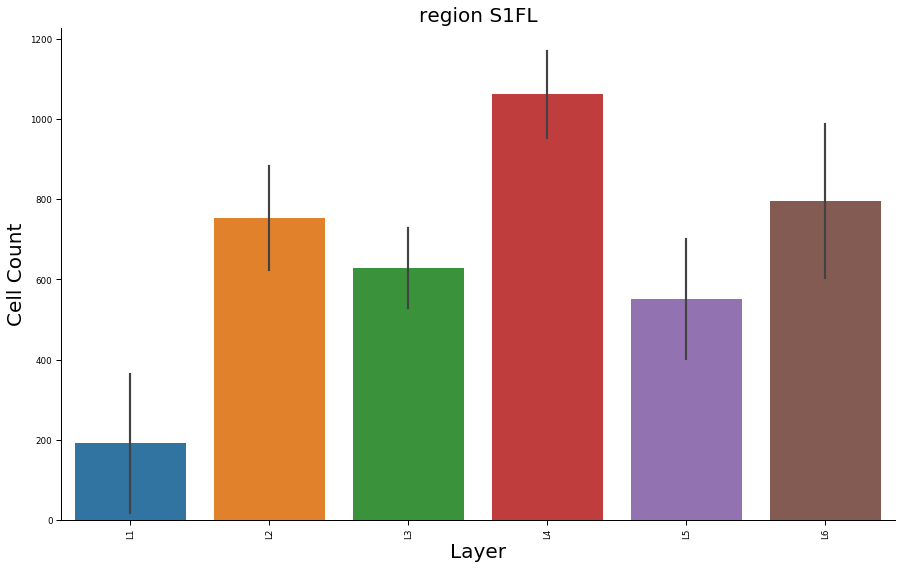

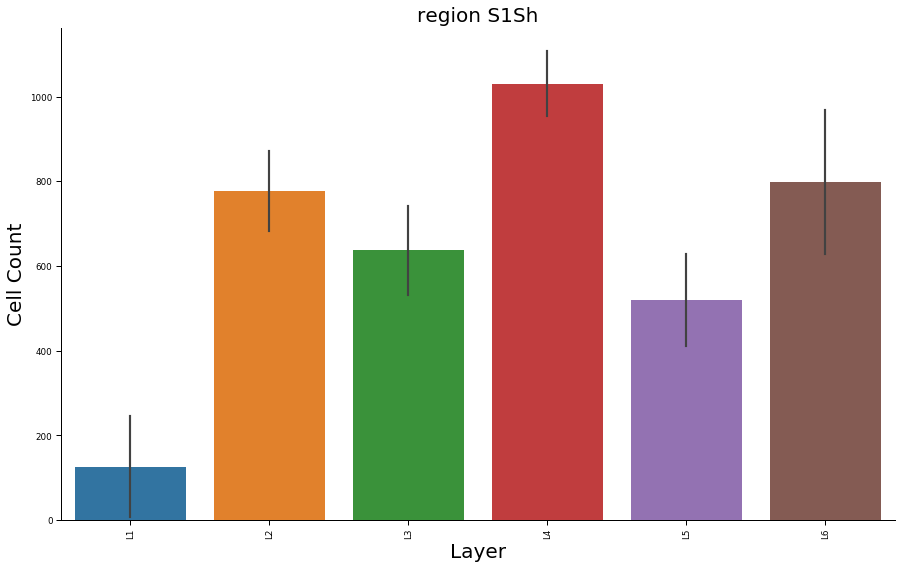

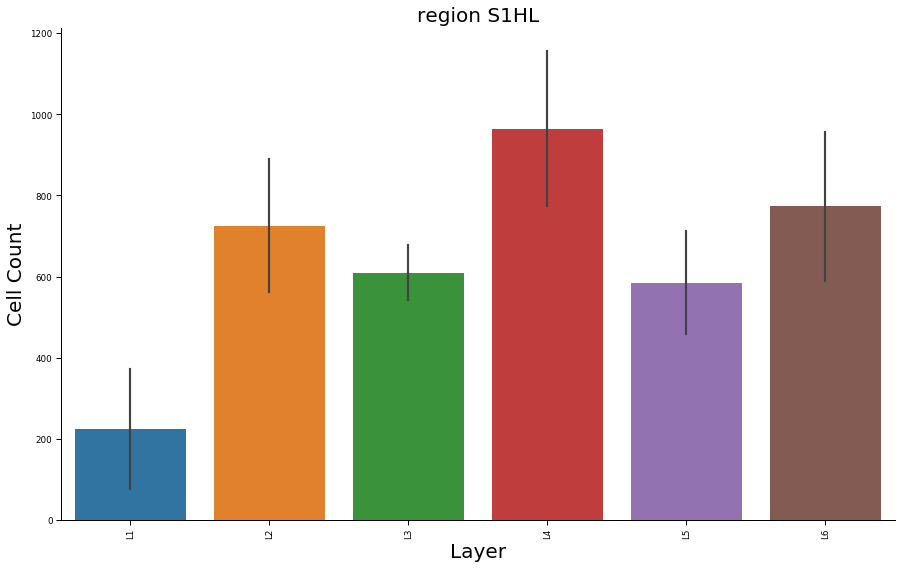

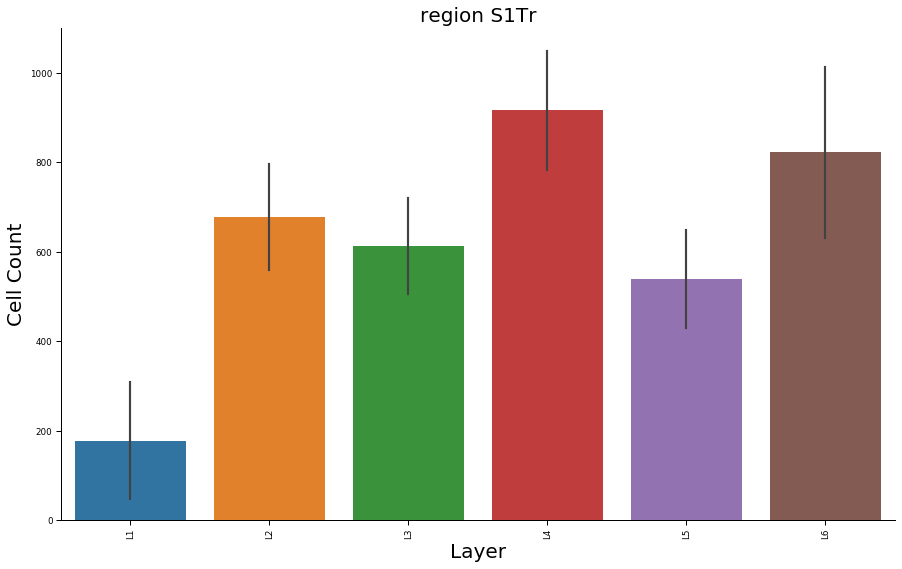

In [21]:
report_cell_count =\
    analysis_cell_count(circuit_model, adapter)

In [50]:
reporter.post(report_cell_count)

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/analysis/reporting/__init__.py Logger
INFO@<2020-03-05 12:29:15>                                                      
Post report cell_count at
	 /Users/vishalsoodmuchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/notebooks/reports/analyses/cell_count/20200305/140738



'/Users/vishalsoodmuchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/notebooks/reports/analyses/cell_count/20200305/140738'

### Cell Density

The number of cells in an volume specified by a region and layer is determined 
by the size of volume.
We can take out the volume by analyzing cell densities.

In [56]:
def measurement_cell_density_using_sampling(
        adapter, circuit_model,
        size_roi=100., **query):
    """
    Measure the density of cells in a spatial location specified by the query.
    """
    box = random_box(adapter, circuit_model, size_roi=size_roi, **query)
    
    if box is None:
        return 0.
    count_cells = adapter.get_cells(circuit_model, roi=box).shape[0]
    volume_spatial = box.volume
    return count_cells / volume_spatial

In [57]:
phenomenon["cell_density"] =\
    Phenomenon("Cell Density", 
               description="Number of cells in a unit volume.",
               group="Composition")
    
analysis_cell_density =\
    BrainCircuitAnalysis(
        phenomenon=phenomenon["cell_density"],
        introduction="""
        Density of cells in each of the populated sub-regions are analyzed.
        """,
        methods="""
        Cells were counted in randomly sampled cubic boxes of side $size_roi.
        Each sampled box was conditioned to lie in the spatial location 
        specified by brain-region and layer queried. For each spatial query,
        the measured sample contained $sample_size boxes.
        """,
        AdapterInterface=CompositionAdapterInterface,
        measurement_parameters=Parameters(get_regions_and_layers),
        sample_measurement=measurement_cell_density_using_sampling,
        sample_size=20,
        plotter=MultiPlot(mvar="region",
                          plotter=Bars(xvar="layer",
                                       xlabel="Layer",
                                       yvar="cell_density",
                                       ylabel="Cell Density")),
        report=CircuitAnalysisReport)





  0%|          | 0/480 [00:00<?, ?it/s]



  1%|▏         | 6/480 [00:00<00:07, 59.47it/s]



  3%|▎         | 13/480 [00:00<00:07, 62.16it/s]



  4%|▍         | 21/480 [00:00<00:06, 66.32it/s]



  6%|▌         | 27/480 [00:00<00:07, 63.19it/s]



  8%|▊         | 36/480 [00:00<00:06, 69.17it/s]



  9%|▉         | 45/480 [00:00<00:05, 74.10it/s]



 11%|█         | 53/480 [00:00<00:05, 75.10it/s]



 13%|█▎        | 62/480 [00:00<00:05, 78.87it/s]



 15%|█▌        | 72/480 [00:00<00:04, 82.59it/s]



 17%|█▋        | 82/480 [00:01<00:04, 85.61it/s]



 19%|█▉        | 91/480 [00:01<00:04, 86.72it/s]



 21%|██        | 100/480 [00:01<00:04, 85.40it/s]



 23%|██▎       | 109/480 [00:01<00:04, 85.04it/s]



 25%|██▍       | 119/480 [00:01<00:04, 87.25it/s]



 27%|██▋       | 128/480 [00:01<00:04, 87.90it/s]



 29%|██▊       | 137/480 [00:01<00:03, 86.25it/s]



 31%|███       | 147/480 [00:01<00:03, 88.42it/s]



 32%|███▎      | 156/480 [00:01<00:03, 83.99it/s]



 35%|███▍  

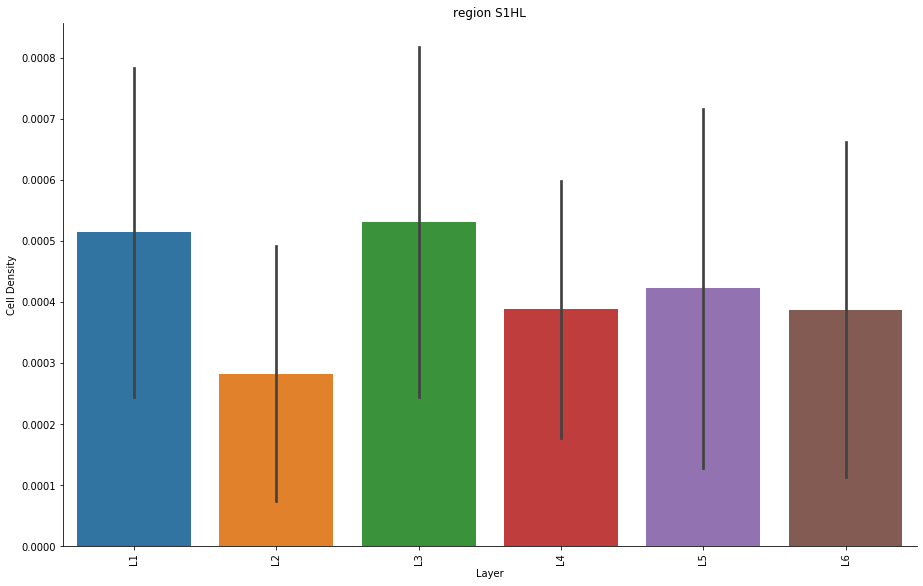

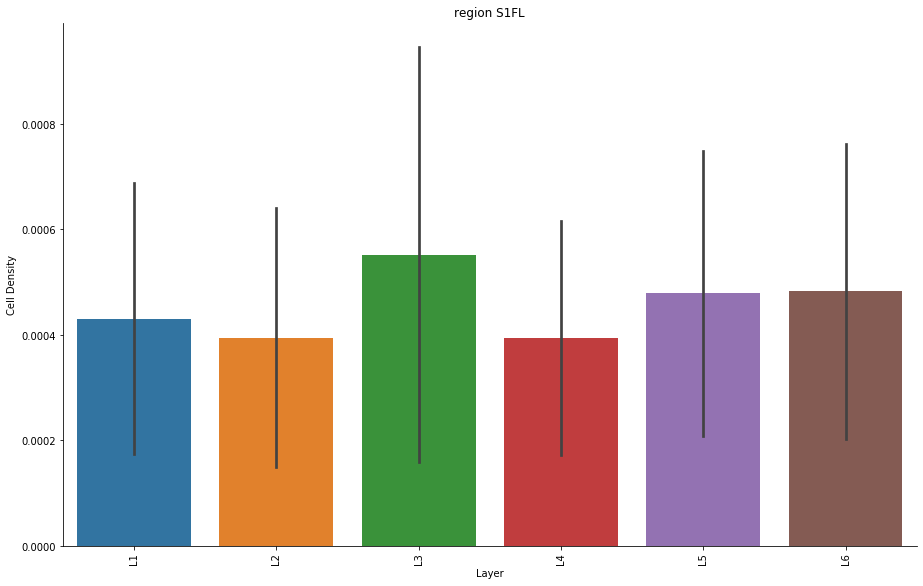

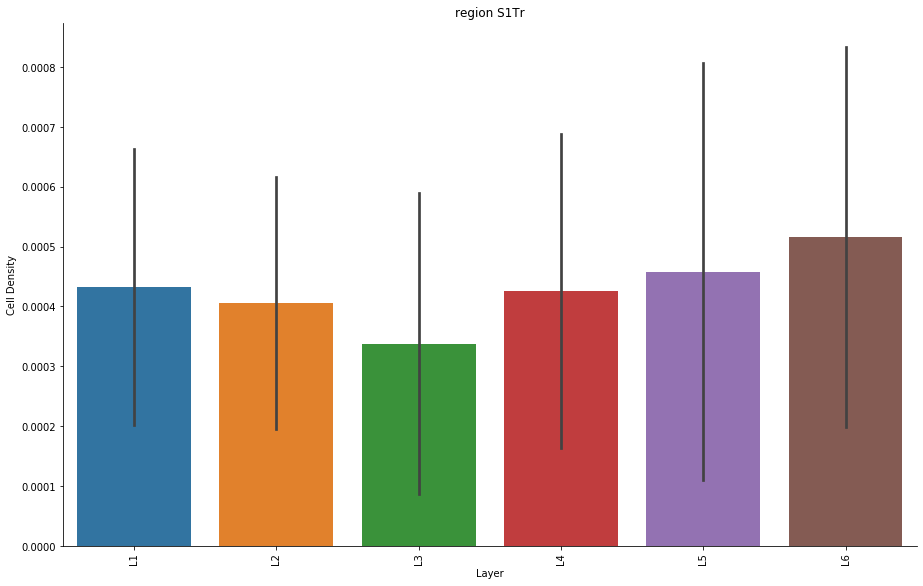

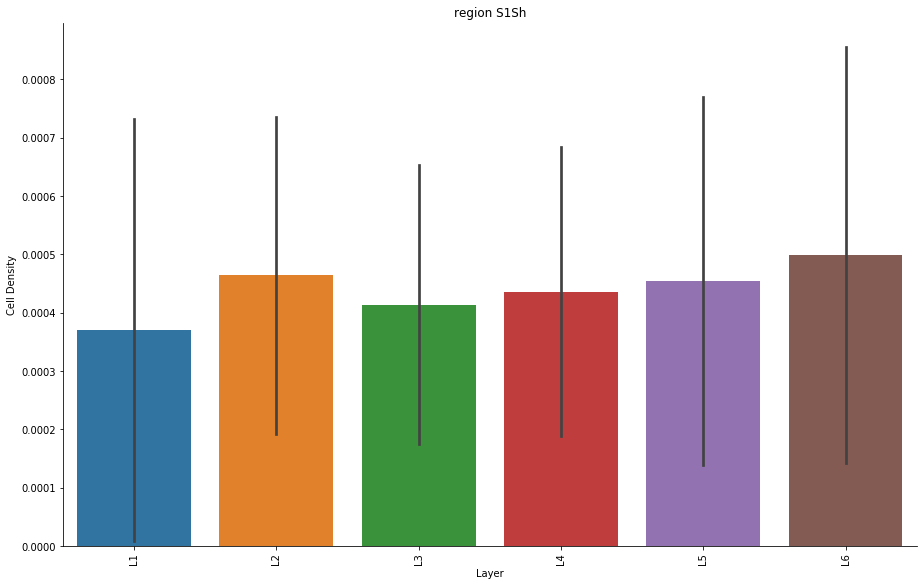

In [58]:
report_cell_density = analysis_cell_density(circuit_model, adapter)

In [59]:
reporter.post(report_cell_density)

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/analysis/reporting/__init__.py Logger
INFO@<2020-03-05 12:29:15>                                                      
Post report cell_density at
	 /Users/vishalsoodmuchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/notebooks/reports/analyses/cell_density/20200305/144025



'/Users/vishalsoodmuchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/notebooks/reports/analyses/cell_density/20200305/144025'

# Connectome

The connectome of a circuit consists of synapses between the cells.

## Efferent connections of cells 

An efferent connection is an outgoing connection,
and the cell in question the pre-synaptic cell.
We have developed to make connectome measurements on the circuit.
We use this tool to define a measurement of efferent degree.

In [45]:
reload(pm)
efferent_degree =\
    pm.PathwayMeasurement(
        direction="EFF",
        value=lambda connections: 1.,
        variable="number_connections_efferent",
        specifiers_cell_type=["mtype"],
        sampling_methodology=terminology.sampling_methodology.exhaustive,
        sample_size=100,
        processing_methodology=terminology.processing_methodology.batch,
        batch_size=1000)

In [46]:
efferent_degree.collect(
    circuit_model, adapter,
    pre_synaptic_cell_group={"mtype": "L23_MC"})

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-06 11:17:05>                                                 
PathwayMeasurement.sample(...)
with sampling methodology exhaustive

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-06 11:17:05>                                                 
PathwayMeasurement._sample_target(...)
{'direction': 'EFF', 'post_synaptic_cell_group': {}, 'pre_synaptic_cell_group': {'mtype': 'L23_MC'}}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 11:17:05>                                                 
Adapter get cells for query: 
target None
{}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-06 11:17:05>                                                 
PathwayMeasurement get_connections
queried gids 312
number connections: 62628

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 11:17:05>                                                 
Adapter get cells for query: 
target None
{}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 11:17:05>                                                 
Model get cells for query
{}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-06 1

(post_synaptic_cell, mtype)
L1_DAC     2.0
L1_DAC     3.0
L1_DAC     2.0
L1_DAC     2.0
L1_DAC     4.0
          ... 
L6_UPC    17.0
L6_UPC    21.0
L6_UPC    21.0
L6_UPC    21.0
L6_UPC    17.0
Name: number_connections_efferent, Length: 23608, dtype: float64

In [47]:
circuit_model.get_thickness()

,L1,L2,L3,L4,L5,L6
0,428.427214,96.131097,352.685450,334.945756,387.464681,246.550244
1,41.915290,460.231785,28.730507,396.830778,409.306781,540.827620
2,637.001437,248.865380,407.614748,131.646930,160.687128,393.107415
3,96.309430,284.845838,304.027091,43.586608,228.031512,155.286219
4,613.830793,368.283948,340.757836,416.896362,132.071490,71.801558
5,618.526485,360.740732,415.065862,354.398062,8.379274,565.311214
6,307.783220,599.690943,605.154481,426.572678,208.540745,210.167949
7,113.782852,76.225587,330.366402,521.645385,167.737735,26.347308
8,320.819687,32.101788,284.956323,531.486312,271.982632,69.624810
9,450.659248,346.519200,274.042573,536.857683,105.947801,370.485004
